In [ ]:
%matplotlib inline

# **Tutorial for fusion along illumination**



[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1NgqqjRaKBr3LF7w4Bk11N-nVRInAxnaR?usp=sharing)

This tutorial shows how to apply Leonardo-Fuse to integrate light-sheet datasets with dual-sided illumination together.


The data used here is available in [zenodo](https://zenodo.org/records/14215090). We use volumes "D1_I0.tif" and "D1_I1.tif" for this tutorial. Here, "I0" and "I1" mean two opposite illumination lenses, while "D1" means the same detection lens.

## **Import packages & data**

In [ ]:
# in case Leonardo is not installed yet
!pip install leonardo_toolset

  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of distributed to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of s3fs to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of s3fs to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# load sample dataset
import pooch
from pathlib import Path
import tifffile

data_path = "./"

source_part1 = pooch.retrieve(
    url="https://zenodo.org/records/14215090/files/D1_I0.tif",
    known_hash="md5:ef10aa423ffc5175cd44284206794ec5",
    fname="D1_I0.tif",
    path=data_path / Path("download"),
)

source_part2 = pooch.retrieve(
    url="https://zenodo.org/records/14215090/files/D1_I1.tif",
    known_hash="md5:b3d68aea26ce0b1e26324f2f588207e0",
    fname="D1_I1.tif",
    path=data_path / Path("download"),
)

X0 = tifffile.imread(source_part1)
X1 = tifffile.imread(source_part2)

## **Start fusion**

First, let's visualize the maximum intensity projection of the two datasets to figure out the orientation of the system:

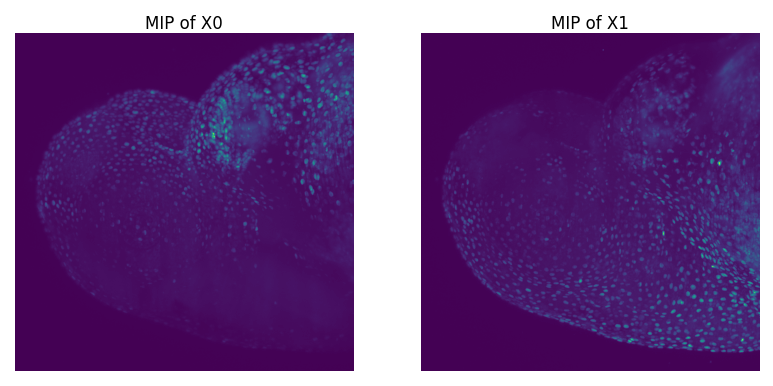

In [ ]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, dpi=150)
ax1.imshow(X0.max(0))
ax1.set_title("MIP of X0", fontsize=8, pad=1)
ax1.axis("off")
ax2.imshow(X1.max(0))
ax2.set_title("MIP of X1", fontsize=8, pad=1)
ax2.axis("off")
plt.show()

We can observe that light sheet comes from top and bottom (in the image space) for volume X0 and X1, respectively.
<br/>
<br/>
Next, we can initialize a `FUSE_illu` object. Here, we initilize FUSE_illu using default parameters. A more advanced list of available arguments can be found in section [API reference](https://leonardo-lsfm.readthedocs.io/en/latest/api.html)




In [ ]:
from leonardo_toolset import FUSE_illu

model = FUSE_illu()

Finally, we start fusion by calling `train` function. datasets X0 and X1 are fed as `top_illu_data` and `bottom_illu_data`, respectively, corresponding to their illumination orientation. The fusion result, together with a few intermidiate results, will be saved in folder `save_folder` under path `save_path`.

Read in...

Localize sample...
           startX    endX startY    endY         maxv
top             0    1024      0    1024  3454.000244
bottom          0    1024      0    1024  2523.999512
in summary    0.0  1024.0    0.0  1024.0  3454.000244


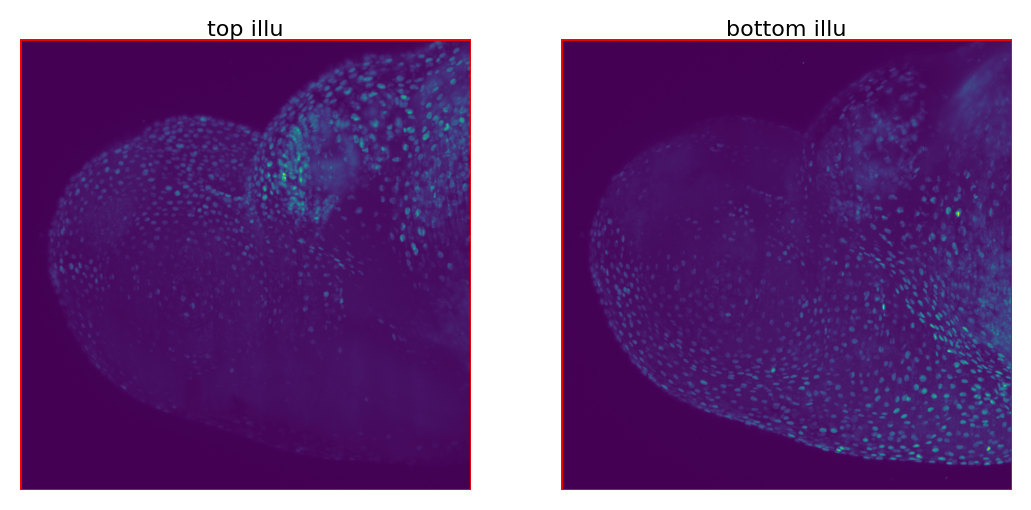


Calculate volumetric measurements...
top/left view: minimum intensity = 57.0, maximum intensity = 2537.0, OTSU threshold = 149.0
bottom/right view: minimum intensity = 61.0, maximum intensity = 2049.0, OTSU threshold = 144.0

Extract features...


NSCT: 100%|██████████| 25/25 [00:59<00:00,  2.36s/it]



Segment sample...


refine along z: 100%|██████████| 2704/2704 [00:02<00:00, 1255.43it/s]



Dual-illumination fusion...
to GPU...
No.049 iteration EM: maximum changes = 1.0
Stitching...


fusion: 100%|██████████| 250/250 [00:49<00:00,  5.05it/s]


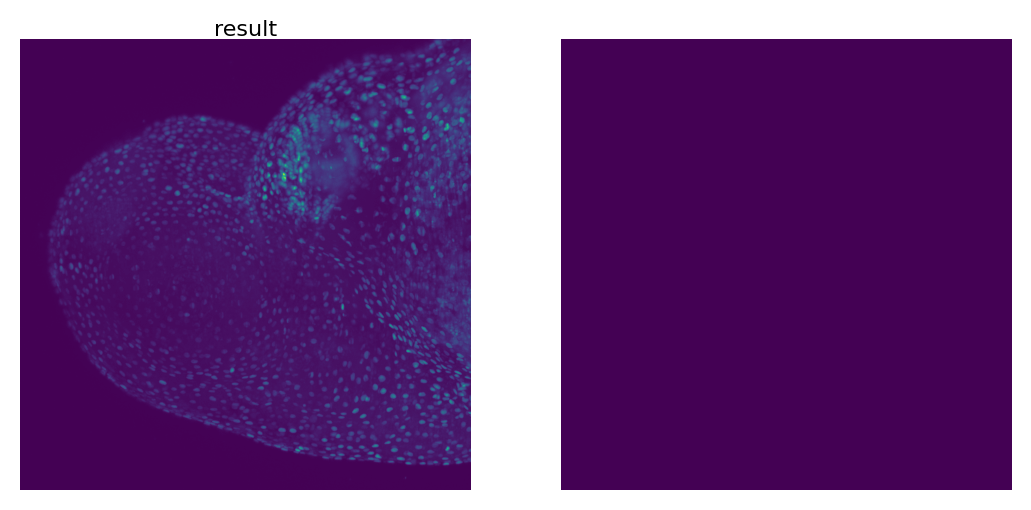

Save...


In [ ]:
# start fusion
save_path = "./"
save_folder = "fuse_illu_result"

out = model.train(top_illu_data = X0,
                  bottom_illu_data = X1,
                  save_path = save_path,
                  save_folder = save_folder,
                  )

## **Note 1: inputs with file names provided**

In reality, to facilitate batch processing, users can also feed in data-to-be-fused without reading them into the memory. To do so, please save the data-to-be-fused in such structure:
```
    data_path
        ├─ sample_name
                    ├─ I0_D1.tif
                    ├─ I1_D1.tif
```
and call the `train` function as follows:

```
out = model.train(data_path = data_path,
                  sample_name = sampel_name,
                  top_illu_data = "I0_D1.tif",
                  bottom_illu_data = "I1_D1.tif",
                  save_path = save_path,
                  save_folder = save_folder,
                  )
```



## **Note 2: fuse datasets with left/right illumination orientations**

Depends on the system, the illumination orientation in then image space can also from left or right. In this way, input datasets should be called by `left_illu_data` and `right_illu_data`, instead of `top_illu_data` and `bottom_illu_data`:
```
out = model.train(left_illu_data = X0, # suppose X0 is illuminated from the left
                  right_illu_data = X1, # suppose X0 is illuminated from the right
                  save_path = save_path,
                  save_folder = save_folder,
                  )
```